In [1]:
import seaborn as sns
import networkx as nx
from scipy.signal import argrelextrema
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm

sns.set()
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 4.0})

plt.style.use(
    'https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from copy import deepcopy

In [32]:

def readEdges(filename):
    edges=np.loadtxt(filename)
    edges.sort(axis=1)
    edges=edges[np.lexsort((edges[:, 1], edges[:, 0]))]
    return edges

def readTrigs(filename):
    trigs=np.loadtxt(filename)
    trigs.sort(axis=1)
    trigs=trigs[np.lexsort((trigs[:, 2], trigs[:, 1], trigs[:, 0]))]
    return trigs


def getRandomWeights(edges):
    return np.random.uniform(size=(edges.shape[0]))


class Graph:
    colors= plt.rcParams["axes.prop_cycle"].by_key()["color"]

    def __init__(self, n, edges, trigs, w, eps0, e):
        self.n, self.edges, self.trigs, self.w, self.eps0, self.e=n, edges, trigs, w, eps0, e
        self.B1=self.B1fromEdges(n, edges)
        self.B2=self.B2fromTrig(n, edges, trigs)

    def B1fromEdges(self, n, edges):
        B1=np.zeros((n, edges.shape[0]))

        for i in range(edges.shape[0]):
            B1[int(edges[i, 0]),i]=-1
            B1[int(edges[i, 1]),i]=1
        return B1

    def B2fromTrig(self, n, edges, trigs):
        B2=np.zeros((edges.shape[0], trigs.shape[0]))

        for i in range(trigs.shape[0]):
            B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 1]])).all(axis=1))[0][0] ,i]=1
            B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 2]])).all(axis=1))[0][0] ,i]=-1
            B2[np.where((edges==np.array([trigs[i, 1], trigs[i, 2]])).all(axis=1))[0][0] ,i]=1
        return B2

    def getW(self):
        return np.diag(np.sqrt(self.w)+self.eps0*self.e)

    def getAdjB1(self):
        return np.diag(np.diag(self.B1 @ self.B1.T))-self.B1 @ self.B1.T
    
    def getAdjB1W(self):
        W=self.getW()
        return np.diag(np.diag(self.B1 @ W @ W @ self.B1.T))-self.B1 @ W @ W @ self.B1.T

    def getPositions(self):
        A=self.getAdjB1()
        temp = nx.from_numpy_matrix(np.array(A))  
        pos = nx.spring_layout(temp)
        return np.array(list(pos.values()))

    def simpleDrawB1(self):
        points=self.getPositions()
        realW=np.diag(self.getW()**2)
        plt.figure(figsize=(8,8))
        plt.plot(points[:,0], points[:,1], 'o', color=self.colors[4], markersize=40)

        for i in range(points.shape[0]):
            plt.text(x=points[i,0], y=points[i,1], s=str(i), va='center', ha='center')

        for i in range(self.edges.shape[0]):
            plt.plot(points[self.edges[i].astype(int), 0], points[self.edges[i].astype(int), 1], color=self.colors[3], linewidth=12*realW[i])
            plt.text(x=np.mean(points[self.edges[i].astype(int), 0]), 
                    y=np.mean(points[self.edges[i].astype(int), 1]), s=str(round(realW[i], 3)), va='center', ha='center',
                    #rotation=180/np.pi*np.arctan(np.diff(points[edges[i].astype(int), 1])[0]/np.diff(points[edges[i].astype(int), 0])[0])
                    color='grey', fontsize=14)
        plt.grid(False)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(r'$\varepsilon=$'+str(round(self.eps0, 3)))


def inv(A, thr=1e-10):
    w=np.diag(A)
    ans=np.zeros(w.shape[0])
    ans=1./w
    return np.diag(ans)

def Sym(A):
    return 0.5*(A+A.T)

def scal(A, B):
    return np.trace(A.T @ B)


def getDt(G, W):
    w_t = np.diag(W).reshape(-1, 1)
    ones2 = np.ones(G.B2.shape[1]).reshape(-1, 1)
    tmp = np.multiply(ones2 @ w_t.T, np.abs(G.B2).T)
    minval=np.zeros(tmp.shape[0])
    for i in range(tmp.shape[0]):
        if (tmp[i, np.nonzero(tmp[i])]).shape[1]==3:
            minval[i]=np.min(tmp[i, np.nonzero(tmp[i])])
    return np.diag(minval)

def getL1(G: Graph):
    W = G.getW()
    Dt = getDt(G, W)
    L1 = W @ G.B1.T @ G.B1 @ W + inv(W) @ G.B2 @ Dt @ Dt @ G.B2.T @ inv(W)
    return L1

def getL0(G: Graph):
    W=G.getW()
    A=G.getAdjB1W()+np.eye(G.B1.shape[0])
    d= (A @ np.ones((A.shape[0], 1))).flatten()
    L0=np.diag(d)-A
    L0=np.diag(np.power(d, -1/2).flatten()) @ L0 @ np.diag(np.power(d, -1/2).flatten())
    return L0

def getFk_l2(G, k, p , thrs):
    return getFk1(G, k, p , thrs)+getFk2(G, k, p , thrs)

def getFk1(G, k, p , thrs):
    L1=getL1(G)
    vals, _=np.linalg.eigh(L1)
    vals.sort()
    return 0.5*np.sum(np.power(vals[:k+p+1], 2))

def getFk2(G, k, p , thrs):
    L0=getL0(G)
    vals, _=np.linalg.eigh(L0)
    vals.sort()
    return 0.5*thrs['alpha']*np.max([ 0, 1-vals[1]/thrs['mu'] ])**2


def getNumGrad(G: Graph, k, p, thrs, thr0, normcor):
    gradNum=np.zeros(G.w.shape[0])
    delt=1e-4
    
    initValue=getFk_l2(G, k, p, thrs)
    W=G.getW()
    for i in range(G.w.shape[0]):
        if np.diag(np.abs(W))[i]>thr0:
            move=np.zeros(G.w.shape[0])
            move[i]=delt
            G1=deepcopy(G)
            G1.e=G1.e+move
            newValue=getFk_l2(G1, k, p, thrs)
            gradNum[i]=(newValue-initValue)/delt

    gradNum=gradNum/G.eps0

    if normcor:
        mask=(np.diag(W)>thr0)
        PE=np.multiply(mask, e)
        GPE=np.multiply(mask, gradNum)
        kappa=-(GPE.T @ PE) / (PE.T @ PE)
        gradNum=GPE+kappa*PE

    return gradNum


def single_run(G: Graph, k, thrs, h0, my_beta, thr0):
    h, fl=h0, 0 
    L1 = getL1(G)
    p=np.sum(np.abs(L1) @ np.ones(G.w.shape)<1e-3)
    track=[getFk_l2(G, k, p, thrs)]
    t_cur, ts=0, [0]
    log, h_log, h_desc=[], [], []
    history, history_de = [G.e], []
    ending, step_num, st_p, jump= 0, 0, 0, 0

    while (track[-1]>1e-5) and (fl==0) and (step_num<=1000):
        e0=G.e
        dE=getNumGrad(G, k, p, thrs, thr0, 1)
        history_de.append(dE)
        if np.max(np.abs(dE))<1e-4:
            fl, ending = 1, 1
            break

        while True:
            e1= G.e-h*dE 
            e1[np.sqrt(G.w)+G.eps0*e1<0]=-1.0/G.eps0 * np.sqrt(G.w[np.sqrt(G.w)+G.eps0*e1<0])
            e1=e1/np.linalg.norm(e1, 2)
            G1=deepcopy(G)
            G1.e=e1
            newval=getFk_l2(G1, k, p, thrs)
            L1_E=getL1(G1)

           #if p != np.sum( np.abs(L1_E) @ np.ones(G.w.shape) < 1e-3 ):
          #      p = np.sum( np.abs(L1_E) @ np.ones(G.w.shape) < 1e-3 )
          #      st_p +=1
          #      newval=getFk_l2(G1, k, p, thrs)
          #      G1.e=e1
          #      jump=1
          #      break

            if (newval < track[-1]) or ( jump ==1 ):
                if jump==0:
                    h*=my_beta
                h_log.append(h)
                h_desc.append(1)
                G.e=G1.e
                jump=0
                break
            else:
                G.e=e0 
                h/=my_beta
                h_log.append(h)
                h_desc.append(2)
            if h<1e-10:
                fl, ending = 1, 2
                break
        vals, _=np.linalg.eigh(L1_E)
        log.append(vals.sort())
        track.append(newval)
        history.append(G.e)
        t_cur+=h
        ts.append(t_cur)
        step_num+=1
    ans=history[-1]
    return ans, track, ts, ending, history, history_de, log, st_p

def alpha_flow(G: Graph, k, alstart, alfinish, thrs, initial):
    my_beta, h0, thr0=1.2, 1e-1, 1e-12
    if not(initial):
        G1=deepcopy(G)
        G1.e=np.ones(G.w.shape)/np.sqrt(G.w.shape[0])
        G1.eps0=1e-4
        L1=getL1(G1)
        p=np.sum(np.abs(L1) @ np.ones(G.w.shape) < 1e-3)
        thrs['alpha']=alstart
        e0=getNumGrad(G1, k, p, thrs, thr0, 1)
        e0=-e0/np.linalg.norm(e0, 2)
        G.e=e0
    else:
        G1=deepcopy(G)
        L1=getL1(G1)
        p=np.sum(np.abs(L1) @ np.ones(G.w.shape) < 1e-3)
        thrs['alpha']=alstart
    
    als=np.power(np.linspace(np.sqrt(alstart), np.sqrt(alfinish), 15), 2)
    e_ans, track, _, ending, _, _, _, _=single_run(G, k, thrs, h0, my_beta, thr0)
    e_log, func_log, endings=[e_ans], [track[-1]], [ending]

    i_start=1
    #if not(initial):
    #    i_start=als.shape[0]

    for i in range(i_start, als.shape[0]):
        G.e=e_ans
        thrs['alpha']=als[i]
        e_ans, track, _, ending, _, _, _, _=single_run(G, k, thrs, h0, my_beta, thr0)
        e_log.append(e_ans)
        func_log.append(track[-1])
        endings.append(ending)

    return e_log, func_log, endings


In [27]:
def wrapper():
    edges=readEdges('4.edges')
    trigs=readTrigs('4.trigs')
    n=4
    #w=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
    w=getRandomWeights(edges)*1.5+0.5

    G=Graph(n, edges, trigs, w, 0, np.zeros(w.shape))

    k=1
    L0=getL0(G)
    vals, _=np.linalg.eigh(L0)
    vals.sort()
    thrs={'mu': 0.9*vals[1],
        'alpha': 0}
    alstart, alfinish=1, 100

    Heps=0.05
    Heps2=Heps/2

    func_fin_forw, es_ans_forw, eps_forw=[], [], []
    func_fin_back, es_ans_back, eps_back=[], [], []

    while True:
        if len(func_fin_forw)>0:
            if func_fin_forw[-1]<1e-5:
                break
        if G.eps0>2.5:
            break
        G.eps0=G.eps0+Heps
        if G.eps0==Heps:
            e_log, func_log, endings=alpha_flow(G, k, alstart, alfinish, thrs, False)
        else:
            e_log, func_log, endings=alpha_flow(G, k, alstart, alfinish, thrs, True)
        #print("eps: ", G.eps0, "   |||  func:  ", func_log[-1])
        G.e=e_log[-1]
        func_fin_forw.append(func_log[-1])
        es_ans_forw.append(e_log[-1])
        eps_forw.append(G.eps0)

    while True:
        if len(func_fin_back)>0:
            if func_fin_back[-1]>1e-1:
                break
        if G.eps0<=0.05:
            break
        G.eps0=G.eps0-Heps2
        e_log, func_log, endings=alpha_flow(G, k, alstart, alfinish, thrs, True)
        #print("eps: ", G.eps0, "   |||  func:  ", func_log[-1])
        G.e=e_log[-1]
        func_fin_back.append(func_log[-1])
        es_ans_back.append(e_log[-1])
        eps_back.append(G.eps0)

    return eps_forw, es_ans_back, func_fin_forw, eps_back, es_ans_forw, func_fin_back, G


In [20]:
w=getRandomWeights(edges)
w

array([0.32317156, 0.33908857, 0.56068264, 0.09926978, 0.59446571])

In [33]:
edges=readEdges('4.edges')
trigs=readTrigs('4.trigs')
n=4
#w=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


G=Graph(n, edges, trigs, w, 0, np.zeros(w.shape))

k=1
L0=getL0(G)
vals, _=np.linalg.eigh(L0)
vals.sort()
thrs={'mu': 0.5*vals[1],
      'alpha': 0}
alstart, alfinish=1, 100

Heps=0.05
Heps2=Heps/2

func_fin_forw, es_ans_forw, eps_forw=[], [], []
func_fin_back, es_ans_back, eps_back=[], [], []

while True:
    if len(func_fin_forw)>0:
        if func_fin_forw[-1]<1e-5:
            break
    if G.eps0>2.5:
        break
    G.eps0=G.eps0+Heps
    if G.eps0==Heps:
        e_log, func_log, endings=alpha_flow(G, k, alstart, alfinish, thrs, False)
    else:
        e_log, func_log, endings=alpha_flow(G, k, alstart, alfinish, thrs, True)
    print("eps: ", G.eps0, "   |||  func:  ", func_log[-1])
    G.e=e_log[-1]
    func_fin_forw.append(func_log[-1])
    es_ans_forw.append(e_log[-1])
    eps_forw.append(G.eps0)

while True:
    if len(func_fin_back)>0:
        if func_fin_back[-1]>1e-1:
            break
    if G.eps0<=0.05:
        break
    G.eps0=G.eps0-Heps2
    e_log, func_log, endings=alpha_flow(G, k, alstart, alfinish, thrs, True)
    print("eps: ", G.eps0, "   |||  func:  ", func_log[-1])
    G.e=e_log[-1]
    func_fin_back.append(func_log[-1])
    es_ans_back.append(e_log[-1])
    eps_back.append(G.eps0)


eps:  0.05    |||  func:   0.8253448205832071
eps:  0.1    |||  func:   0.7308233808310173
eps:  0.15000000000000002    |||  func:   0.6317446789277544
eps:  0.2    |||  func:   0.5318091315271223
eps:  0.25    |||  func:   0.4406579345821223
eps:  0.3    |||  func:   0.33314593712674956
eps:  0.35    |||  func:   0.2623156139455287
eps:  0.39999999999999997    |||  func:   0.2107593675061291
eps:  0.44999999999999996    |||  func:   0.17036233303247028
eps:  0.49999999999999994    |||  func:   0.1373138315223805
eps:  0.5499999999999999    |||  func:   0.10981624597707748
eps:  0.6    |||  func:   0.08683780466149378
eps:  0.65    |||  func:   0.06767859155189992
eps:  0.7000000000000001    |||  func:   0.05181181882212469
eps:  0.7500000000000001    |||  func:   0.038812765424348174
eps:  0.8000000000000002    |||  func:   0.028322333346430945
eps:  0.8500000000000002    |||  func:   0.02406147718427781
eps:  0.9000000000000002    |||  func:   0.023863385512761848
eps:  0.95000000000

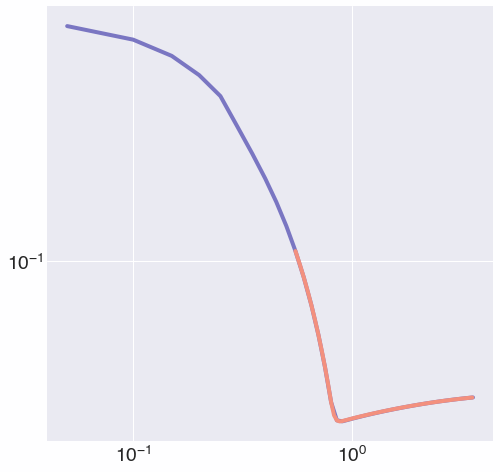

In [34]:
plt.figure(figsize=(8, 8))

plt.loglog(eps_forw, func_fin_forw, color=colors[0])
plt.loglog(eps_back, func_fin_back, color=colors[4])

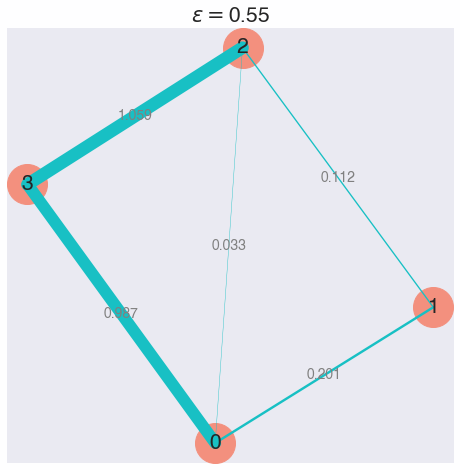

In [35]:
eps_fin, e_fin=getAnswerFromBack(eps_back, es_ans_back, func_fin_back)
eps_fin
G.simpleDrawB1()

In [24]:
L0=getL0(G)
np.linalg.eigvalsh(L0), thrs["mu"]

(array([1.20137748e-16, 2.76159417e-01, 2.76165138e-01, 1.87017441e+00]),
 0.3003834225206409)

In [28]:
def getAnswerFromBack(eps_back, es_ans_back, func_fin_back):
    return eps_back[np.where(np.array(func_fin_back)>1e-5)[0][0]-1], es_ans_back[np.where(np.array(func_fin_back)>1e-5)[0][0]-1]

In [ ]:
eps_fin, e_fin=getAnswerFromBack(eps_back, es_ans_back, func_fin_back)
eps_fin

1.0000000000000044

NameError: ignored

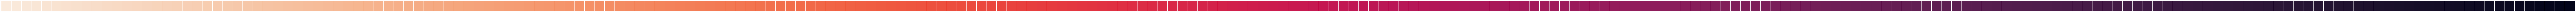

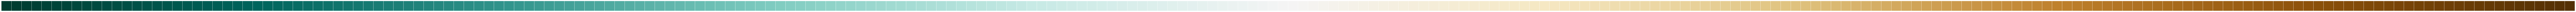

In [6]:
from matplotlib import cm


my_cmap = sns.color_palette("rocket_r", n_colors=256)
sns.palplot(my_cmap)

my_cmap2 = sns.color_palette("BrBG_r", n_colors=256)
sns.palplot(my_cmap2)

cm_tr2=np.array(my_cmap2[round(p*len(my_cmap2)):round((1-p)*len(my_cmap2))])
indx2=np.round((e_fin+1)/2*len(cm_tr2)).astype(int)
indx2[indx2==len(cm_tr2)]-=1
sns.palplot(cm_tr2[indx2])

In [ ]:
a=getRandomWeights(G.edges)
a

array([0.29714177, 0.96533862, 0.55833821, 0.62796195, 0.89182146,
       0.2557859 , 0.0077551 , 0.35015503, 0.49542441, 0.00854517])

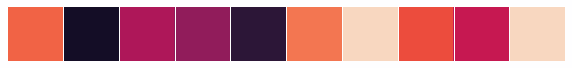

In [ ]:
p=0.05
cm_tr=np.array(my_cmap[round(p*len(my_cmap)):round((1-p)*len(my_cmap))])
indx=np.round((a-np.min(a))/(np.max(a)-np.min(a))*len(cm_tr)).astype(int)
indx[indx==len(cm_tr)]-=1
sns.palplot(cm_tr[indx])

In [7]:
import matplotlib.patches as patches

rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

NameError: ignored

In [8]:
def lineDraw(ax, ycur, h_sq, h_sp, a, edges, e_fin, eps_forw, eps_back, func_fin_forw, func_fin_back, colors):

    my_cmap = sns.color_palette("rocket_r", n_colors=256)
    p=0.05
    cm_tr=np.array(my_cmap[round(p*len(my_cmap)):round((1-p)*len(my_cmap))])
    indx=np.round(a/2*len(cm_tr)).astype(int)
    indx[indx==len(cm_tr)]-=1

    my_cmap2 = sns.color_palette("BrBG_r", n_colors=256)
    cm_tr2=np.array(my_cmap2[round(p*len(my_cmap2)):round((1-p)*len(my_cmap2))])
    indx2=np.round((e_fin+1)/2*len(cm_tr2)).astype(int)
    indx2[indx2==len(cm_tr2)]-=1


    ax.text(x=3, y=10.5, s='weights', fontweight=400, va='center', ha='center')

    for i in range(a.shape[0]):
        rect = patches.Rectangle((i*h_sq+i*h_sp, ycur), h_sq, h_sq, linewidth=1, edgecolor='none', facecolor=cm_tr[indx][i])
        ax.add_patch(rect)
        if indx[i]<=70:
            ax.text(x=i*h_sq+i*h_sp+0.5*h_sq, y=ycur+0.5*h_sq, s=str(round(a[i], 2)),
                    va='center', ha='center', fontsize=11)
        else:
            ax.text(x=i*h_sq+i*h_sp+0.5*h_sq, y=ycur+0.5*h_sq, s=str(round(a[i], 2)),
                    va='center', ha='center', fontsize=11, color='white')
        if ycur==9:
            ax.text(x=i*h_sq+i*h_sp+0.5*h_sq, y=9.65+0.5*h_sq, s=str(int(edges[i][0])),
                        va='center', ha='center', fontsize=11, color='grey')
            ax.text(x=i*h_sq+i*h_sp+0.5*h_sq, y=9.4+0.5*h_sq, s=str(int(edges[i][1])),
                        va='center', ha='center', fontsize=11, color='grey')

    ax.text(x=12, y=10.5, s='perturbation', fontweight=400, va='center', ha='center')
    for i in range(a.shape[0]):
        rect = patches.Rectangle((9+i*h_sq+i*h_sp, ycur), h_sq, h_sq, linewidth=1, edgecolor='none', facecolor=cm_tr2[indx2][i])
        ax.add_patch(rect)
        if (indx2[i]>=70) and (indx2[i]<=140):
            ax.text(x=9+i*h_sq+i*h_sp+0.5*h_sq, y=ycur+0.5*h_sq, s=str(round(e_fin[i], 2)),
                    va='center', ha='center', fontsize=11)
        else:
            ax.text(x=9+i*h_sq+i*h_sp+0.5*h_sq, y=ycur+0.5*h_sq, s=str(round(e_fin[i], 2)),
                    va='center', ha='center', fontsize=11, color='white')
        if ycur==9:
            ax.text(x=9+i*h_sq+i*h_sp+0.5*h_sq, y=9.65+0.5*h_sq, s=str(int(edges[i][0])),
                        va='center', ha='center', fontsize=11, color='grey')
            ax.text(x=9+i*h_sq+i*h_sp+0.5*h_sq, y=9.4+0.5*h_sq, s=str(int(edges[i][1])),
                        va='center', ha='center', fontsize=11, color='grey')

    ax.text(x=7.5, y=10.5, s='func.', fontweight=400, va='center', ha='center')
    rect = patches.Rectangle((6.75, ycur), 1.5, 1, linewidth=1, edgecolor='lightgrey', facecolor="none")
    ax.add_patch(rect)

    xlog, xlog2=np.log(eps_forw), np.log(eps_back)
    ylog, ylog2=np.log(func_fin_forw), np.log(func_fin_back)
    ymax=np.max([ np.max(ylog), np.max(ylog2) ])
    ymin=np.min([ np.min(ylog), np.min(ylog2) ])
    ydist=ymax-ymin
    ymax+=2*p*ydist
    ymin-=2*p*ydist
    
    xmax=np.max([ np.max(xlog), np.max(xlog2) ])
    xmin=np.min([ np.min(xlog), np.min(xlog2) ])
    xdist=xmax-xmin
    xmax+=2*p*xdist
    xmin-=2*p*xdist

    xn=(xlog-xmin)/(xmax-xmin)*1.5+6.75
    yn=(ylog-ymin)/(ymax-ymin)*1.+ycur

    xn2=(xlog2-xmin)/(xmax-xmin)*1.5+6.75
    yn2=(ylog2-ymin)/(ymax-ymin)*1.+ycur

    ax.plot(xn, yn, color=colors[0], linewidth=3)
    ax.plot(xn2, yn2, color=colors[1], linewidth=3)


1
2
3
4
5
6
7


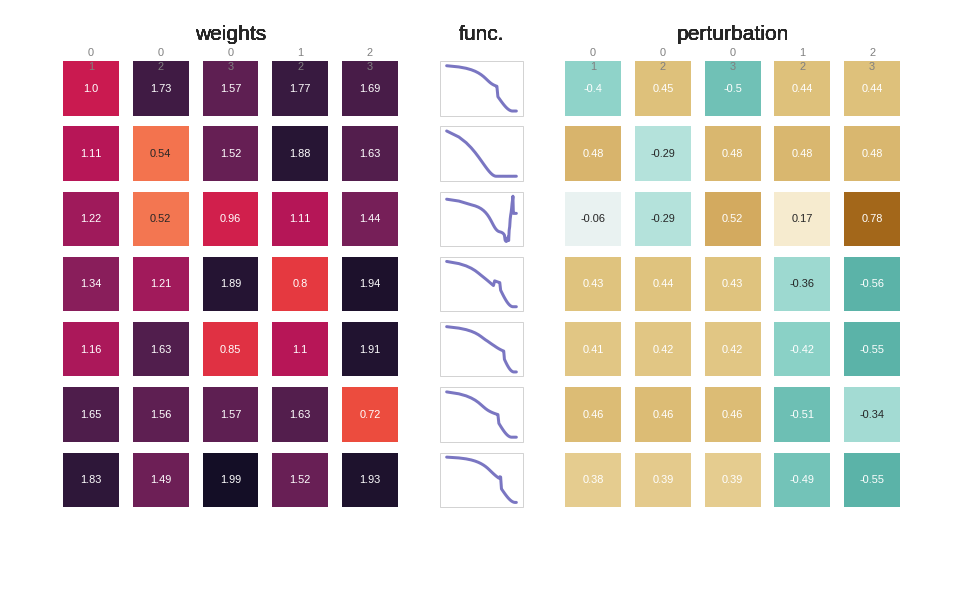

In [28]:
with sns.axes_style("whitegrid"):
    fig, ax=plt.subplots(1,1, figsize=(17, 11))
    plt.grid(False)
    plt.xlim([-1, 16])
    plt.ylim([0, 11])
    
    h_sp=6.0/(5*5-1)
    h_sq=4*h_sp

    ycur=9
    
    eps_forw, es_ans_back, func_fin_forw, eps_back, es_ans_forw, func_fin_back, G=wrapper()
    eps_fin, e_fin=getAnswerFromBack(eps_back, es_ans_back, func_fin_back)
    print(1)
    lineDraw(ax, ycur, h_sq, h_sp, G.w, G.edges, e_fin, eps_forw, eps_back, func_fin_forw, func_fin_back, colors)

    ycur=7.8
    eps_forw, es_ans_back, func_fin_forw, eps_back, es_ans_forw, func_fin_back, G=wrapper()
    eps_fin, e_fin=getAnswerFromBack(eps_back, es_ans_back, func_fin_back)
    print(2)
    lineDraw(ax, ycur, h_sq, h_sp, G.w, G.edges,e_fin, eps_forw, eps_back, func_fin_forw, func_fin_back, colors)

    ycur=6.6
    eps_forw, es_ans_back, func_fin_forw, eps_back, es_ans_forw, func_fin_back, G=wrapper()
    eps_fin, e_fin=getAnswerFromBack(eps_back, es_ans_back, func_fin_back)
    print(3)
    lineDraw(ax, ycur, h_sq, h_sp, G.w, G.edges,e_fin, eps_forw, eps_back, func_fin_forw, func_fin_back, colors)

    ycur=5.4
    eps_forw, es_ans_back, func_fin_forw, eps_back, es_ans_forw, func_fin_back, G=wrapper()
    eps_fin, e_fin=getAnswerFromBack(eps_back, es_ans_back, func_fin_back)
    print(4)
    lineDraw(ax, ycur, h_sq, h_sp, G.w, G.edges,e_fin, eps_forw, eps_back, func_fin_forw, func_fin_back, colors)

    ycur=4.2
    eps_forw, es_ans_back, func_fin_forw, eps_back, es_ans_forw, func_fin_back, G=wrapper()
    eps_fin, e_fin=getAnswerFromBack(eps_back, es_ans_back, func_fin_back)
    print(5)
    lineDraw(ax, ycur, h_sq, h_sp, G.w, G.edges,e_fin, eps_forw, eps_back, func_fin_forw, func_fin_back, colors)

    ycur=3.0
    eps_forw, es_ans_back, func_fin_forw, eps_back, es_ans_forw, func_fin_back, G=wrapper()
    eps_fin, e_fin=getAnswerFromBack(eps_back, es_ans_back, func_fin_back)
    print(6)
    lineDraw(ax, ycur, h_sq, h_sp, G.w, G.edges,e_fin, eps_forw, eps_back, func_fin_forw, func_fin_back, colors)

    ycur=1.8
    eps_forw, es_ans_back, func_fin_forw, eps_back, es_ans_forw, func_fin_back, G=wrapper()
    eps_fin, e_fin=getAnswerFromBack(eps_back, es_ans_back, func_fin_back)
    print(7)
    lineDraw(ax, ycur, h_sq, h_sp, G.w, G.edges,e_fin, eps_forw, eps_back, func_fin_forw, func_fin_back, colors)

    frame = plt.gca()
    frame.axes.get_xaxis().set_ticks([])
    frame.axes.get_yaxis().set_ticks([])

    plt.savefig('4test.pdf', format='pdf')

In [20]:
plt.savefig('8test.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

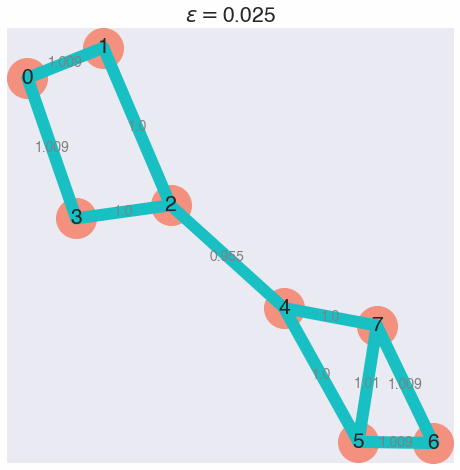

In [ ]:
G.simpleDrawB1()